### 1
Соберём ниже итоговый код классификатора с основной части.<br>
Допишем туда новый оптимизатор Adam, и посмотрим, как будет обучаться наша модель.

In [1]:
import re
from collections import defaultdict, Counter
import sys
import numpy as np
from math import log
from scipy.sparse import csr_matrix, dok_matrix
import string
from itertools import dropwhile
import time
import matplotlib.pyplot as plt

In [2]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ''.join(sym if (sym.isalnum() or sym in (" ", "'")) else f" {sym} " for sym in text)
    return text

In [3]:
def tokenize_dataset(dataset, stem=0):
    """
        arg: list of texts
        return: list of tokenized texts
    """
    stop_words = ['film', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
                  "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
                  'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
                  'themselves', 'what', 'which', 'who', 'whom', 'this', 
                  'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
                  'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                  'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
                  'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
                  'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
                  'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
                  'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
                  't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                  've', 'y', 'ain', 'aren', "aren't", 'could', 'couldn', "couldn't", 'didn', "didn't", 'doesn',
                  "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
                  "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]  + [c for c in string.punctuation]
    tokenizer = re.compile(r"-?\d*[.,]?\d+|[?'\w]+|\S", re.MULTILINE | re.IGNORECASE)
    tokenized_dataset = list(map(lambda doc: tokenizer.findall(doc), dataset))
    if stem == 0:
        return [[token for token in text if token not in stop_words] for text in tokenized_dataset]
    stem_dataset = [[token[:stem] for token in text if token not in stop_words] for text in tokenized_dataset]
    return stem_dataset

In [4]:
def gen_w2ind(tokenized_texts, min_tf=1, max_df=1, min_df=1, bigrams=False, trigrams=False):
    start = time.perf_counter()
    print("w2ind started")
    df_cnt = defaultdict(int)
    all_cnt = defaultdict(int)
    free_ind = 0
    for text in tokenized_texts:
        been = set()
        tokens = text[:]
        if bigrams:
            tokens += list(zip(text[:-1], text[1:]))
        if trigrams:
            tokens += list(zip(text[:-2], text[1:-1], text[2:]))
        for token in tokens:
            all_cnt[token] += 1
            if token not in been:
                df_cnt[token] += 1
                been.add(token)

    for w, cnt in list(all_cnt.items()):
        if cnt < min_tf:
            del all_cnt[w]
            del df_cnt[w]

    corpus_size = len(tokenized_texts)
    for w, cnt in list(df_cnt.items()):
        if cnt < min_df or cnt / corpus_size > max_df:
            del all_cnt[w]
            del df_cnt[w]

    w2ind = {w: ind for ind, w in enumerate(all_cnt.keys())}
    w_sorted = sorted(list(w2ind.items()), key=lambda x: x[1])
    idf = np.array([0] + [np.log((1 + corpus_size) / (1 + df_cnt[w])) + 1 for w, _ in w_sorted])

    finish = time.perf_counter()
    print(f"DICTS GENERATED IN {finish - start} seconds.")
    return w2ind,  idf

In [5]:
def vectorize(tokenized_texts, w2ind, idfs, mode='tf-idf', bigrams=False, trigrams=False, intercept=True):
    start = time.perf_counter()
    print("vectorize started")
    X = dok_matrix((len(tokenized_texts), len(w2ind) + intercept), dtype=np.float32)
    for ind, text in enumerate(tokenized_texts):
        tokens = text[:]
        if bigrams:
            tokens += list(zip(text[:-1], text[1:]))
        if trigrams:
            tokens += list(zip(text[:-2], text[1:-1], text[2:]))
        for token in tokens:
            if token in w2ind:
                token_ind = w2ind[token]
                if intercept:
                    token_ind += 1
                X[ind, token_ind] += 1
    
    if mode == 'bin':
        X = (X > 0).astype('float32')
    elif mode == 'tf':
        X = X.tocsr()
        X = X.multiply(1 / X.sum(1))
    elif mode == 'idf':
        X = (X > 0).astype('float32').multiply(idfs)
    elif mode == 'tf-idf':
        X = X.tocsr()
        X = X.multiply(1 / X.sum(1))
        X = X.multiply(idfs)


    if intercept:
        X = X.tolil()
        X[:, 0] = 1

    finish = time.perf_counter()
    print(f"VECTORIZED IN {finish - start} seconds.")
    return X.tocsr()

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=2):
    """
    Генератор новых батчей для обучения
    """

    X_all = X
    y_all = y
    indices = np.arange(X_all.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    for i in range(0, X_all.shape[0], batch_size):
        if len(indices[i: i + batch_size]) != batch_size:
            break
        X_batch = X_all[indices[i: i + batch_size]]
        y_batch = y_all[indices[i: i + batch_size]]
        yield (X_batch, y_batch)

In [7]:
def sigmoid(x):
    np.clip(x, -100, 100)
    sig = 1 / (1 + np.exp(-x))
    sig = np.minimum(sig, 1.0 - np.finfo(np.float32).eps)
    sig = np.maximum(sig, 0.0 + np.finfo(np.float32).eps)
    return sig

In [8]:
class LogisticRegression:
    def __init__(self, num_ep, lr, batch_size, l2_reg, optimizer='SGD', beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.num_ep = num_ep
        self.lr = lr
        self.batch_size = batch_size
        self.l2_reg = l2_reg
        self.optimizer = optimizer
        self.batch_generator = batch_generator
        self.weights = None
        self.m = None
        self.v = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.train_info = ([], [], [])
        self.dev_info = ([], [], [])

    def update_w_def(self, new_grad):
        self.weights = self.weights - self.lr * new_grad

    def update_w_adam(self, new_grad, it):
        self.m = self.beta1 * self.m + (1. - self.beta1) * new_grad
        self.mt = self.m / (1 - self.beta1 ** it)
        self.v = self.beta2 * self.v + (1. - self.beta2) * new_grad ** 2
        self.vt = self.v / (1 - self.beta1 ** it)
        self.weights = self.weights - self.lr * self.mt / (np.sqrt(self.vt) + self.epsilon)

    def update_weights(self, data):
        if self.optimizer == 'SGD':
            self.update_w_def(*data)
        elif self.optimizer == 'Adam':
            self.update_w_adam(*data)

    def loss_grad(self, X, y):
        y_pred = sigmoid(X.dot(self.weights))
        loss = (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()
        loss += self.l2_reg * (self.weights ** 2).mean()

        y_lab = (y_pred > 0.5).astype(np.int32)
        acc = (y_lab == y).sum() / y_lab.shape[0]

        grad = X.T.dot(y_pred - y) / y.shape[0]
        grad += 2 * self.l2_reg * np.insert(self.weights[1:], 0, 0, axis=0)
        return loss, acc, grad

    def fit(self, X, y, dev_dataset=None):

        self.weights = np.zeros(X.shape[1])
        self.m = np.zeros(X.shape[1])
        self.v = np.zeros(X.shape[1])
        total_steps = 1

        for cur_ep in range(0, self.num_ep):
            if cur_ep % 1 == 0:
                loss, acc, _ = self.loss_grad(X, y)
                self.train_info[0].append(cur_ep)
                self.train_info[1].append(loss)
                self.train_info[2].append(acc)
                if dev_dataset:
                    X_dev, y_dev = dev_dataset
                    loss, acc, _ = self.loss_grad(X_dev, y_dev)
                    self.dev_info[0].append(cur_ep)
                    self.dev_info[1].append(loss)
                    self.dev_info[2].append(acc)

            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size, shuffle=True)
            for ind, (X_batch, y_batch) in enumerate(new_epoch_generator):
                loss, acc, grad = self.loss_grad(X_batch, y_batch)
                update_data = [grad, total_steps]
                self.update_weights(update_data)
                total_steps += 1

                if cur_ep != 0 and cur_ep % 7 == 0:
                    self.lr *= np.exp(-0.2)
        return self

    def predict(self, X):
        y_pred = sigmoid(X.dot(self.weights))
        y_lab = (y_pred > 0.5).astype(np.int32)
        return y_lab

In [9]:
train_texts_path = "./filimdb_evaluation/FILIMDB/train.texts"
train_labels_path = "./filimdb_evaluation/FILIMDB/train.labels"

with open(train_texts_path, 'r', encoding='utf-8',) as inp:
    train_texts = list(map(str.strip, inp.readlines()))
with open(train_labels_path, 'r', encoding='utf-8',) as inp:
    train_labels = list(map(str.strip, inp.readlines()))
    

proc_train = list(map(preprocessing, train_texts))
token_train = tokenize_dataset(proc_train)

w2ind_train, idf = gen_w2ind(token_train, bigrams=True, trigrams=False)
X_train = vectorize(token_train, w2ind=w2ind_train, idfs=idf, mode='default', bigrams=True, trigrams=False)
y_train = np.array([int(lab == 'pos') for lab in train_labels])

w2ind started
DICTS GENERATED IN 5.8771461999999985 seconds.
vectorize started
VECTORIZED IN 85.2970458 seconds.


In [10]:
val_texts_path = "./filimdb_evaluation/FILIMDB/dev.texts"
val_labels_path = "./filimdb_evaluation/FILIMDB/dev.labels"

with open(val_texts_path, 'r', encoding='utf-8') as inp:
    val_texts = list(map(str.strip, inp.readlines()))
with open(val_labels_path, 'r', encoding='utf-8') as inp:
    val_labels = list(map(str.strip, inp.readlines()))
    
proc_val = list(map(preprocessing, val_texts))
token_val = tokenize_dataset(proc_val)

X_val = vectorize(token_val, w2ind=w2ind_train, idfs=idf, mode='default', bigrams=True, trigrams=False)
y_val = np.array([int(lab == 'pos') for lab in val_labels])

vectorize started
VECTORIZED IN 39.97794640000001 seconds.


In [11]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / y_true.shape[0]

In [12]:
def show_info(info, title="Train"):
    fig = plt.figure(figsize=(15, 7))
    ax_acc = fig.add_subplot(221)
    ax_acc.plot(info[0], info[2], 'r--')
    ax_acc.title.set_text(title + ' ' + "accuracy")
    ax_loss = fig.add_subplot(222)
    ax_loss.plot(info[0], info[1], 'r--')
    ax_loss.title.set_text(title + ' ' +  "loss")
    plt.show()


Train accuracy =  1.0


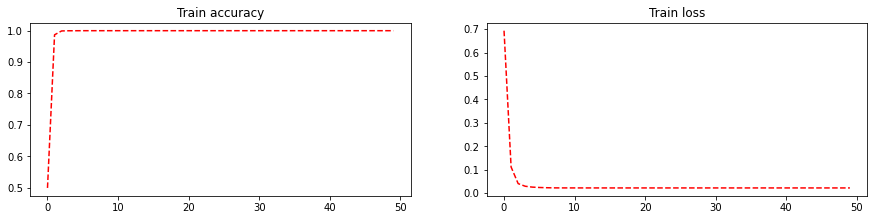

Dev accuracy =  0.896


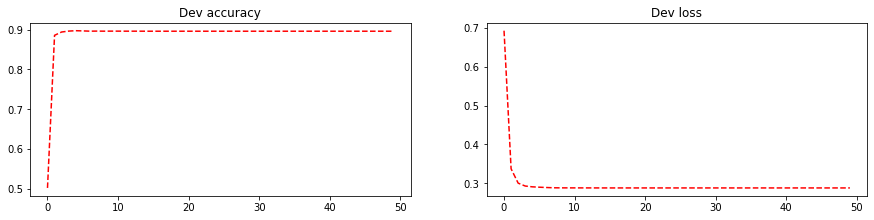

In [13]:
train_dataset = (X_train, y_train)
dev_dataset = (X_val, y_val)

# model = LogisticRegression(num_ep=40, lr=0.001, l2_reg=1e-4, batch_size=4096, optimizer='Adam')
model = LogisticRegression(num_ep=50, lr=0.001, l2_reg=3e-5, batch_size=1000, optimizer='Adam')
fitted = model.fit(X_train, y_train, dev_dataset=dev_dataset)

train_info, dev_info = fitted.train_info, fitted.dev_info

y_train_pred = fitted.predict(X_train)
print("Train accuracy = ", accuracy(y_train, y_train_pred))
show_info(train_info)
y_val_pred = fitted.predict(X_val)
print("Dev accuracy = ", accuracy(y_val, y_val_pred))
show_info(dev_info, title="Dev")

Я решил реализовать Adam, т.к. считается, что он наиболее хорошо работает из коробки. И действительно, это позволило модели обучаться быстрее и получить немного больше точности.

### 3

Попробуем сначала **tf-idf** векторизацию, как наиболее известную.

In [14]:
train_texts_path = "./filimdb_evaluation/FILIMDB/train.texts"
train_labels_path = "./filimdb_evaluation/FILIMDB/train.labels"

with open(train_texts_path, 'r', encoding='utf-8',) as inp:
    train_texts = list(map(str.strip, inp.readlines()))
with open(train_labels_path, 'r', encoding='utf-8',) as inp:
    train_labels = list(map(str.strip, inp.readlines()))
    

proc_train = list(map(preprocessing, train_texts))
token_train = tokenize_dataset(proc_train)

w2ind_train, idf = gen_w2ind(token_train, min_tf = 2, max_df = 0.3, bigrams=True, trigrams=True)
X_train = vectorize(token_train, w2ind=w2ind_train, idfs=idf, mode='tf-idf', bigrams=True, trigrams=True)
y_train = np.array([int(lab == 'pos') for lab in train_labels])

w2ind started
DICTS GENERATED IN 8.01512409999998 seconds.
vectorize started
VECTORIZED IN 64.57413930000001 seconds.


In [15]:
val_texts_path = "./filimdb_evaluation/FILIMDB/dev.texts"
val_labels_path = "./filimdb_evaluation/FILIMDB/dev.labels"

with open(val_texts_path, 'r', encoding='utf-8') as inp:
    val_texts = list(map(str.strip, inp.readlines()))
with open(val_labels_path, 'r', encoding='utf-8') as inp:
    val_labels = list(map(str.strip, inp.readlines()))
    
proc_val = list(map(preprocessing, val_texts))
token_val = tokenize_dataset(proc_val)

X_val = vectorize(token_val, w2ind=w2ind_train, idfs=idf, mode='tf-idf', bigrams=True, trigrams=True)
y_val = np.array([int(lab == 'pos') for lab in val_labels])

vectorize started
VECTORIZED IN 37.45418319999999 seconds.


(15000, 263017)
Train accuracy =  0.9874666666666667


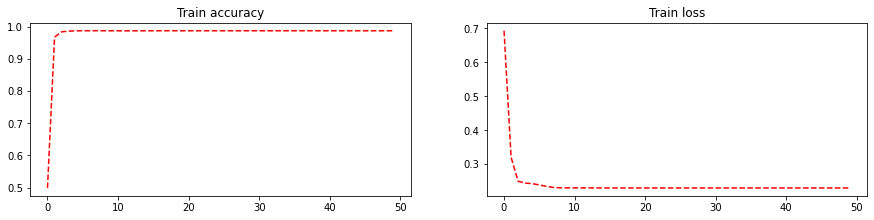

Dev accuracy =  0.8884


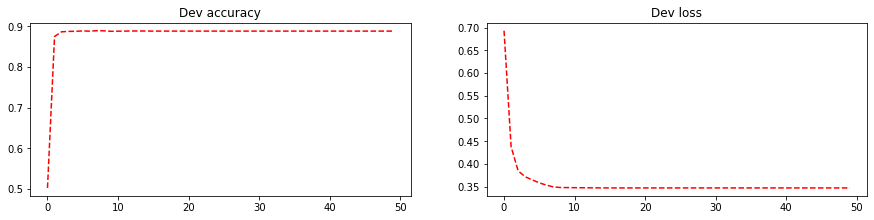

In [16]:
train_dataset = (X_train, y_train)
dev_dataset = (X_val, y_val)
print(X_train.shape)

# model = LogisticRegression(num_ep=40, lr=0.001, l2_reg=1e-4, batch_size=4096, optimizer='Adam')
model = LogisticRegression(num_ep=50, lr=0.01, l2_reg=5e-6, batch_size=1000, optimizer='Adam')
fitted = model.fit(X_train, y_train, dev_dataset=dev_dataset)

train_info, dev_info = fitted.train_info, fitted.dev_info

y_train_pred = fitted.predict(X_train)
print("Train accuracy = ", accuracy(y_train, y_train_pred))
show_info(train_info)
y_val_pred = fitted.predict(X_val)
print("Dev accuracy = ", accuracy(y_val, y_val_pred))
show_info(dev_info, title="Dev")

Я также попробовал векторизации tf, просто idf, и бинарную. Все они проигрывали обычной векторизации с подсчетом слов.<br>
Возможно не хватало нормализации, но у меня не хватило времени подобрать гиперпараметры для того, чтобы другие векторизации обгоняли обычную.

### 3

Посмотрим, какие же примеры модель классифицирует неправильно.

In [18]:
with open('wrong_pred.txt', 'r') as inp:
    wrong_texts = list(map(str.split, inp.readlines()))
for text in wrong_texts[:3]:
    print(' '.join(text))

fleet released middle depression people tough time worldwide finding jobs even finding food put table europe hitler rise along nationalist socialist whackjobs united states seeds cartel sown federal reserve act income tax amendment beginning bear fruit connected finance capitalists dominating secret societies average guy girl times tough enter hollywood least hopeful images В— think properly call propaganda point even though particular movie revolves around war preparatory naval exercises real issue boys girls hook right one lead decent life wonderful children modicum grace elegance odds long complete review movie movie book reviews please visit site thecoffeecoaster com brian wright copyright
first saw live musical denver center performing arts absolutely mind blowing stunning fantastic continuity plot dialogue liked much musicals seen stage interesting thing never got see zach's face always dark presence powerful guided direction entire production whe heard making movie waited bated 

Я посмотрел глазами на тексты которые модель классифицировала неправильно. В первый раз мне удалось найти ошибку в предобработке.(не правильно удалялись теги и знаки препинания)<br> 
После этого стало заметно, что очень много неправильных текстов содержат опечатки и в итоге я добавил отсечку по **min_df = 2**, что также позволило улучшить результат.<br>
После я прочитал второй отзыв из представленных выше, понял, что с таким бороться бесполезно и оставил идею смотреть неправильные классификации.(Текстов было очень много, они все были очень разные и никаких сходств я между ними не увидел.)